## An analysis of detailed COVID-19 case data published by Public Health Agency of Canada

The code in this notebook was used fo this CBC News report:

[We looked at every confirmed COVID-19 case in Canada. Here's what we found](https://www.cbc.ca/news/canada/public-health-agency-of-canada-covid-19-statistics-1.5733069)

The analysis was done in Python 3.8 using the folowing libraries:

- pandas
- matplotlib
- plotly
- seaborn
- requests

Plotly charts may not display in GitHub. You may need to donwload this notebook and install the [plotly widget for Jupyter](https://plotly.com/python/getting-started/).

### Load and prepare the data

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

Download the lastest data from Statistics Canada. This also unzips the files.

In [2]:
import zipfile, requests, io

data_url = 'https://www150.statcan.gc.ca/n1/pub/13-26-0003/2020001/COVID19-eng.zip'

r = requests.get(data_url, stream=True)
print('Downloading table')
z = zipfile.ZipFile(io.BytesIO(r.content))
print('Extracting data')
z.extractall()

Extracting data


Load the unzipped CSV into a pandas data frame.

In [4]:
epi = pd.read_csv('COVID19-eng.csv', na_values = [99], dtype = str) 

# Pandas is loading the columns loading incorrectly for some reason. This shifts them 1 to the right
epi = epi.shift(1, axis = 1)
epi['Case identifier number'] = epi.index
epi.head()

,Case identifier number,Region,Episode week,Episode week group,Episode year,Gender,Age group,Occupation,Asymptomatic,Onset week of symptoms,...,"Symptom, pain","Symptom, irritability","Symptom, diarrhea","Symptom, other",Hospital status,Recovered,Recovery week,Recovery year,Death,Transmission
1,1,3,52,0,20,1,6,9,2,52,...,9,9,9,9,2,9,NaN,NaN,9,9
2,2,2,1,0,21,2,4,4,2,NaN,...,9,9,9,9,3,9,NaN,NaN,9,9
3,3,2,1,0,21,2,4,2,2,1,...,9,9,9,9,3,9,NaN,NaN,9,9
4,4,2,45,0,20,2,1,4,2,45,...,9,9,9,1,3,1,46,20,2,9
5,5,4,52,0,20,2,1,4,9,NaN,...,9,9,9,9,3,1,NaN,NaN,2,1


A lot of the fields are encoded with ordinal values. This cell maps these numbers to their corresponding values for easier analysis.

In [5]:
gender_map = {'1' : 'Male', '2' : 'Female', '9' : 'Other/Not stated'}

region_map = {'1' : 'Atlantic', '2' : 'Quebec', '3' : 'Ontario and Nunavut', 
              '4' : 'Prairies and NWT', '5' : 'BC and YK'}

age_map = {'1' : '0 to 19', '2' : '20 to 29', '3' : '30 to 39',
               '4' : '40 to 49', '5' : '50 to 59', '6' : '60 to 69',
               '7' : '70 to 79', '8' : '80 years or older', '99' : 'Not stated'}

occupation_map = {'1' : 'Health care worker', '2' : 'School or daycare worker/attendee', 
                  '3' : 'Long term care resident', '4': 'Other', '9' : 'Not stated'}

hosp_map = {'1' : 'Hospitalized and in ICU', '2' : 'Hospitalized, not in ICU', 
            '3' : 'Not hospitalized', '9' : 'Not Stated/Unknown'}

transmission_map = {'1' : 'Domestic acquisition', '2' : 'International travel' , '9' : 'Not stated'}

other_map = {'1' : 'Yes', '2' : 'No', '9' : 'Not Stated', np.nan : np.nan}

Apply the column mappings and create a new column with the week date from the week number.

In [6]:
epi['Week of'] = pd.to_datetime('20' + epi['Episode year'] + '-' + epi['Episode week']+'-0', format = '%Y-%U-%w')

epi.Region = epi.Region.map(region_map)
epi.Gender = epi.Gender.map(gender_map)
epi['Age group'] = epi['Age group'].map(age_map)
epi.Occupation = epi.Occupation.map(occupation_map)
epi['Hospital status'] = epi['Hospital status'].map(hosp_map)
epi['Transmission'] = epi['Transmission'].map(transmission_map)

other_cols = ['Asymptomatic', 'Death', 'Recovered', 'Symptom, chills', 'Symptom, cough', 
              'Symptom, diarrhea', 'Symptom, fever', 'Symptom, headache', 'Symptom, irritability',
               'Symptom, nausea', 'Symptom, other', 'Symptom, pain', 'Symptom, runny nose', 
              'Symptom, shortness of breath','Symptom, sore throat', 'Symptom, weakness']

epi.loc[: , other_cols ] = epi.loc[: , other_cols].applymap(lambda x: other_map[x])

Number of entries in the data:

In [7]:
len(epi)

666237

## Analysis

Cases by age group by week

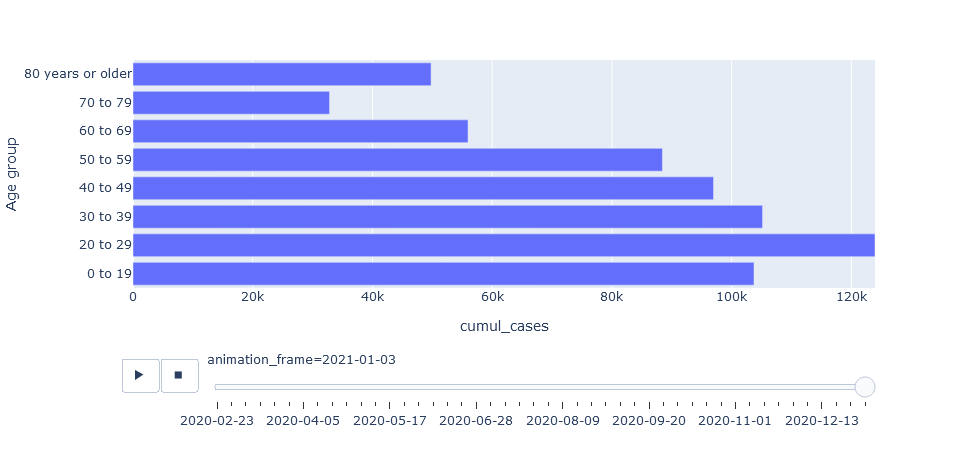

In [53]:
# This outputs an animated Plotly bar chart

ages_by_week = epi.groupby(['Week of', 'Age group']).size().reset_index(name = 'cases')
ages_by_week.sort_values(['Week of', 'Age group'], inplace = True)

# Calculate cumulative cases from the weekly case counts
ages_by_week['cumul_cases'] = ages_by_week.groupby('Age group').cases.cumsum()

px.bar(ages_by_week, x = 'cumul_cases', y = 'Age group', 
       animation_frame = ages_by_week['Week of'].astype(str), range_x = (0, ages_by_week.cumul_cases.max()))

Rate of increase by age group. Same data, but as a line chart.


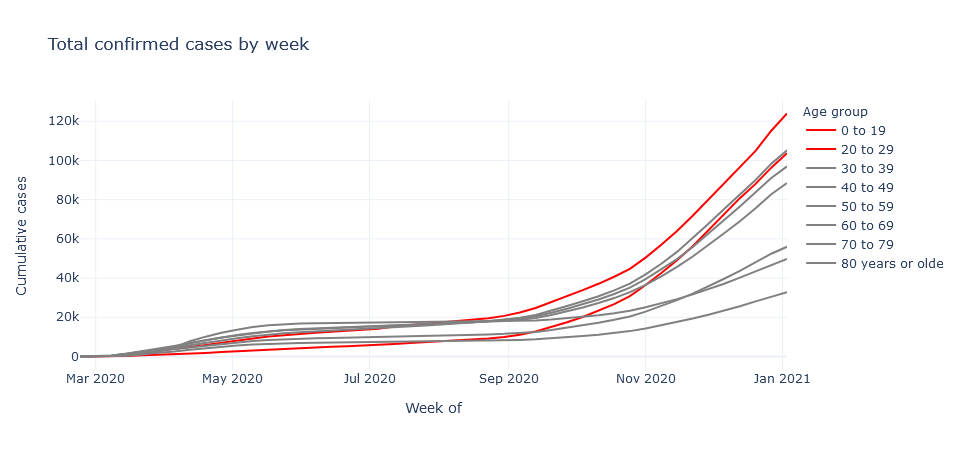

In [37]:
cases_by_age_weeks = epi.groupby(['Week of', 'Age group']).size().reset_index(name = 'New cases')
cases_by_age_weeks.sort_values('Week of', inplace = True)
cases_by_age_weeks['Cumulative cases'] = cases_by_age_weeks.groupby('Age group')['New cases'].cumsum()

colors = dict(zip(cases_by_age_weeks['Age group'].unique(), ['red']*2 + ['grey']*6  ))

px.line(cases_by_age_weeks, x = 'Week of', y = 'Cumulative cases', 
        title = 'Total confirmed cases by week', template='plotly_white',
        color = 'Age group', color_discrete_map = colors)

### Hospitalizations

Cases by hospital status. This adds a row for total hospitalized.

In [54]:
hosp_status = epi.groupby('Hospital status').size().reset_index(name = 'count')
hosp_status = hosp_status.append({'Hospital status':'Total hospitalized', 
                    'count' : hosp_status.iloc[:2].sum()['count']},
                  ignore_index=True).set_index('Hospital status')
hosp_status

,count
Hospital status,
Hospitalized and in ICU,6755
"Hospitalized, not in ICU",30686
Not Stated/Unknown,181554
Not hospitalized,447242
Total hospitalized,37441


Show it as a bar chart.

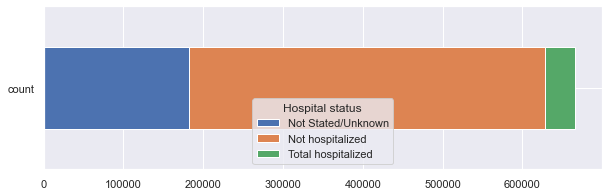

In [55]:
hosp_status.T.iloc[:, 2:].plot.barh(stacked = True, figsize = (10,3))

Hospitalization by age group

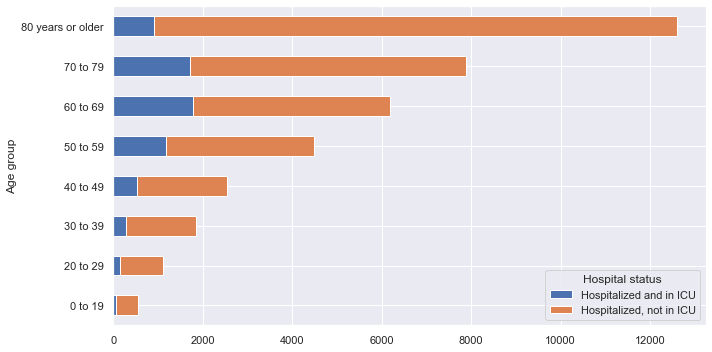

In [56]:
hosp_age = epi.groupby(['Age group', 'Hospital status']).size().unstack()
hosp_age[['Hospitalized and in ICU', 'Hospitalized, not in ICU']].plot.barh(stacked = True, figsize = (10,5))
plt.tight_layout()
plt.savefig('charts/hosp_age.png')

By age group over time

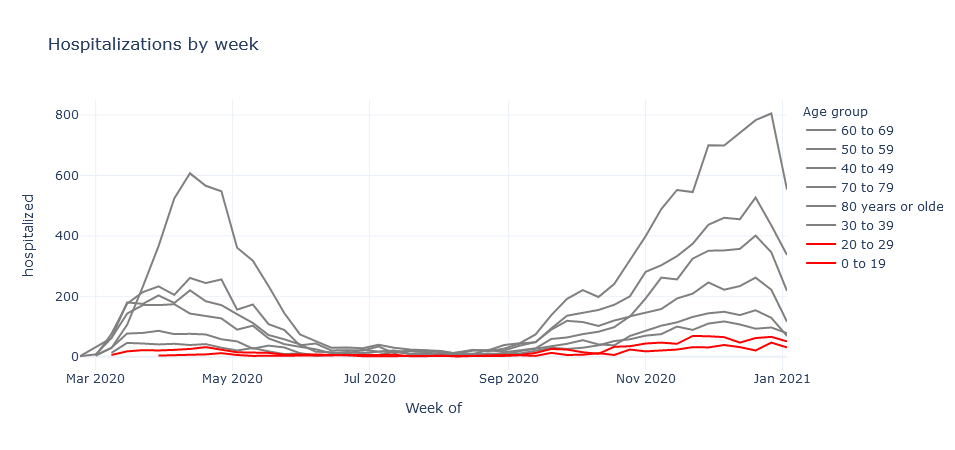

In [58]:
hosp_age_time = (epi[epi['Hospital status'].str.contains('Hospitalized')]
                 .groupby(['Age group', 'Week of'])
                 .size().reset_index(name = 'hospitalized'))
hosp_age_time.sort_values('Week of', inplace = True)

px.line(hosp_age_time, x = 'Week of', y = 'hospitalized', 
        title = 'Hospitalizations by week', template='plotly_white',
        color = 'Age group', color_discrete_map = colors)

Hospitalizations by gender

In [59]:
gender_hosp = epi.groupby(['Hospital status', 'Gender']).size().unstack(1)
gender_hosp.loc['Total hospitalized'] = gender_hosp.iloc[:2].sum()
gender_hosp

Gender,Female,Male,Other/Not stated
Hospital status,,,
Hospitalized and in ICU,2491,4251,13
"Hospitalized, not in ICU",15323,15327,36
Not Stated/Unknown,91280,89187,1087
Not hospitalized,234499,212416,327
Total hospitalized,17814,19578,49


Deaths vs. hospitalization


In [60]:
hospmort = epi.groupby(['Hospital status', 'Death']).size().unstack().iloc[:2, :]
hospmort

Death,No,Not Stated,Yes
Hospital status,,,
Hospitalized and in ICU,3979,900,1876
"Hospitalized, not in ICU",21129,4005,5552


### Deaths

Isolate deaths in the data

In [61]:
deaths = epi[epi.Death == 'Yes']
deaths.describe()

<ipython-input-61-7e2501ada7d1>:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Case identifier number,Region,Episode week,Episode week group,Episode year,Gender,Age group,Occupation,Asymptomatic,Onset week of symptoms,...,"Symptom, irritability","Symptom, diarrhea","Symptom, other",Hospital status,Recovered,Recovery week,Recovery year,Death,Transmission,Week of
count,17170,17170,16020,17170,17058,17170,16898,17170,17170,10164,...,17170,17170,17170,17170,17170,0,0,17170,17170,16020
unique,17170,5,45,1,2,3,4,5,3,45,...,3,3,3,4,1,0,0,1,3,45
top,646063,Quebec,15,0,20,Female,80 years or older,Other,No,15,...,Not Stated,Not Stated,Not Stated,Not hospitalized,No,NaN,NaN,Yes,Domestic acquisition,2020-04-12 00:00:00
freq,1,8330,1459,17170,16858,8819,12053,14011,14182,821,...,16544,16392,12160,8069,17170,NaN,NaN,17170,13805,1459
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-03 00:00:00


Deaths by gender

In [62]:
deaths.Gender.value_counts()

Female              8819
Male                8309
Other/Not stated      42
Name: Gender, dtype: int64

Cumulative deaths by gender over time

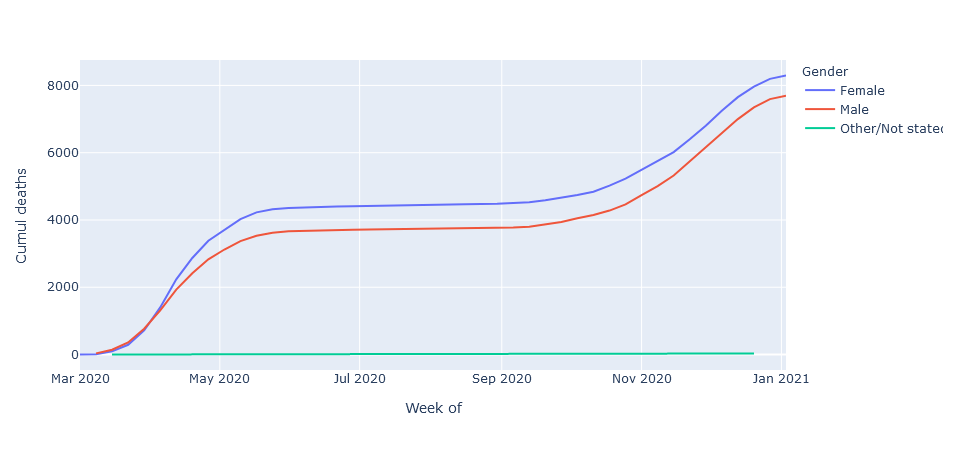

In [64]:
# This outputs an interactive Plotly line chart

deaths_week = deaths.groupby(['Week of', 'Gender']).size().reset_index(name = 'deaths')
deaths_week.sort_values('Week of', inplace = True)
deaths_week['Cumul deaths'] = deaths_week.groupby('Gender').deaths.cumsum()

px.line(deaths_week, x = 'Week of', y = 'Cumul deaths', color = 'Gender')

Deaths by age and gender. This data doesn't conlude deaths under 50. For this, it's better to use the aggregate [PHAC epidemiological summary](https://health-infobase.canada.ca/covid-19/epidemiological-summary-covid-19-cases.html).

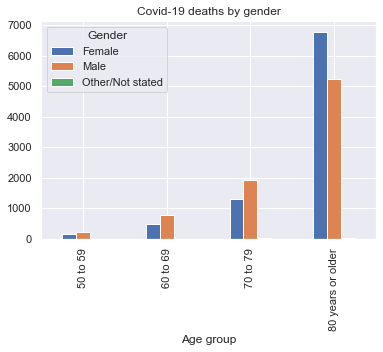

In [65]:
deaths_age = deaths.groupby(['Age group', 'Gender']).size().unstack()

deaths_age.plot.bar(title = "Covid-19 deaths by gender")

Death rate over time. This is the number of deaths divided by total cases by week.

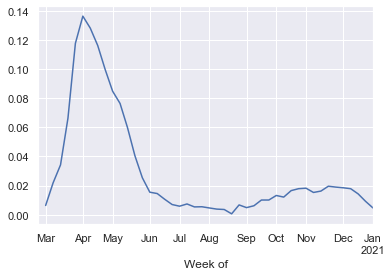

In [66]:
epi.groupby(['Week of', 'Death']).size().unstack().apply(lambda x: x/ x.sum(), axis = 1).Yes.plot()

### Symptoms

Symptoms are noted in individulas columns for each, as `Yes`, `No`, or `Not reported`. To get an idea of symptoms frequency, you need to sum the `Yes` and `No` values and calculate how many are `Yes`.

In [8]:
# Isolate symptom columns
sympt = [c for c in epi.columns if 'Symptom' in c]

# Create a dataframe of symptom counts
sympdf = epi[sympt].apply(pd.Series.value_counts).T
sympdf

,Not Stated,Yes,No
"Symptom, cough",575521,84800,5916
"Symptom, fever",589836,67689,8712
"Symptom, chills",632405,30624,3208
"Symptom, sore throat",606928,50580,8729
"Symptom, runny nose",620603,42097,3537
"Symptom, shortness of breath",626355,28840,11042
"Symptom, nausea",643026,17930,5281
"Symptom, headache",586771,72259,7207
"Symptom, weakness",625740,37890,2607
"Symptom, pain",616505,46082,3650


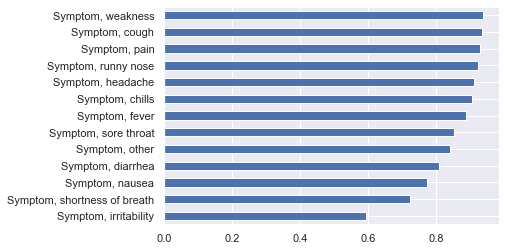

In [68]:
# Most common symptoms overall

sympdf[['Yes', 'No']].div(sympdf.Yes + sympdf.No, axis = 0).sort_values('Yes').Yes.plot.barh()

Rough idea of how many cases have symptom information

In [69]:
(sympdf.No + sympdf.Yes).median()

45634.0

Calculate frequency of symptoms by age. The table below shows the percentage of cases by age of where a symptom is `Yes`.

In [70]:
symptoms_age = (epi.melt(id_vars = 'Age group', value_vars=sympt, var_name='Symptom')
 .groupby(['Age group', 'Symptom', 'value']).size()
 .unstack()
 .reset_index()
 .assign(prop = lambda x: x.Yes / (x.No + x.Yes) * 100)
 .pivot(index = 'Symptom', columns = 'Age group', values = 'prop')
 )

symptoms_age

Age group,0 to 19,20 to 29,30 to 39,40 to 49,50 to 59,60 to 69,70 to 79,80 years or older
Symptom,,,,,,,,
"Symptom, chills",85.662100,92.438472,92.626800,93.290507,92.088460,88.651415,79.756469,67.405063
"Symptom, cough",89.814066,92.373640,93.411181,95.153709,94.834249,94.267013,93.342863,93.280573
"Symptom, diarrhea",71.842561,82.030548,81.254026,84.382470,83.012366,79.141960,77.357320,80.082742
"Symptom, fever",87.887453,86.193019,88.498129,90.514331,89.416645,88.044249,87.956469,90.850537
"Symptom, headache",89.810076,92.779564,92.626544,93.527884,91.882706,88.018504,79.241071,73.871092
"Symptom, irritability",49.459877,60.441767,59.637077,64.366128,57.432432,51.062092,57.638889,73.483536
"Symptom, nausea",71.160714,80.179257,78.241206,80.801172,79.191176,73.758562,69.679540,73.833206
"Symptom, other",79.960864,83.671957,84.448366,85.614549,85.809821,84.887711,83.535393,86.126034
"Symptom, pain",83.937008,93.619176,94.451307,95.857872,94.542958,91.191710,85.145482,83.646813


Visualize that as a Seaborn heatmap.

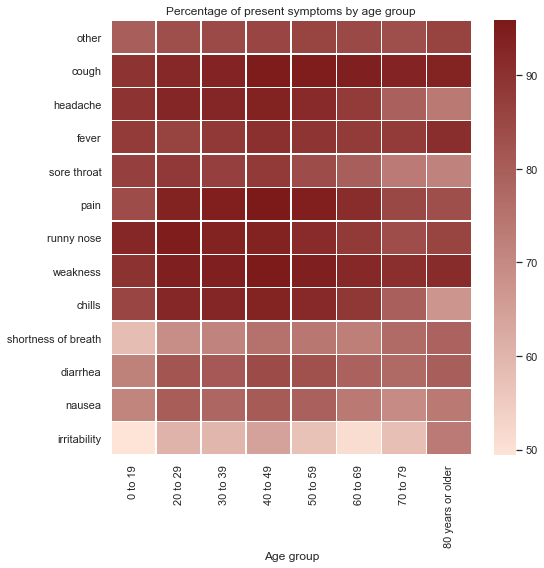

In [71]:
# Create a custom colour gradient using CBC reds.
from matplotlib.colors import LinearSegmentedColormap 
    
cmap = LinearSegmentedColormap.from_list(name='CBC red', 
                                         colors =['#fee3d7', '#7c1919'])

# Order index by most common symptom overall
sym_order = sympdf.sort_values('Yes', ascending = False).index
symptoms_age = symptoms_age.reindex(sym_order)

# REmvoer the word "Symptom" from the index
symptoms_age.index = symptoms_age.index.str.replace('Symptom, ', '')

# Plot it
plt.figure(figsize=(8,8))
sns.heatmap(symptoms_age, linewidths=.5, cmap=cmap)
plt.title('Percentage of present symptoms by age group')
plt.tight_layout()

Do the same with hospitalization status, sorting by most common symptom in hospitalized cases.

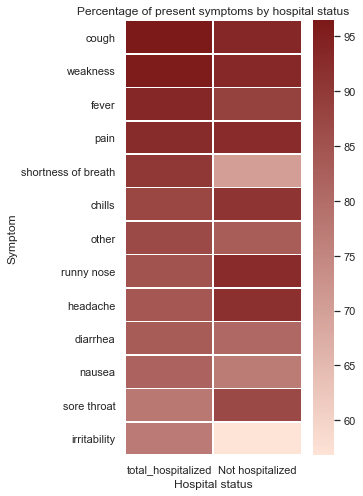

In [72]:
symptoms_hosp =  (epi.melt(id_vars = 'Hospital status', value_vars=sympt, var_name='Symptom')
  .groupby(['Hospital status', 'Symptom', 'value']).size()
  .unstack(0)
  .assign(total_hospitalized = lambda x: x['Hospitalized and in ICU'] + x['Hospitalized, not in ICU'])
  .stack().unstack(1)
  .reset_index()
  .assign(prop = lambda x: x.Yes / (x.No + x.Yes) * 100)
  .pivot(index = 'Symptom', columns = 'Hospital status', values = 'prop')
  .sort_values('total_hospitalized', ascending = False)
 )
symptoms_hosp.index = symptoms_hosp.index.str.replace('Symptom, ', '')


plt.figure(figsize=(5,7))
sns.heatmap(symptoms_hosp[['total_hospitalized', 'Not hospitalized']] , linewidths=.5, cmap = cmap)
plt.title('Percentage of present symptoms by hospital status')
plt.tight_layout()

And with fatal vs. non-fatal cases.

In [73]:
symptoms_death =  (epi.melt(id_vars = 'Death', value_vars=sympt, var_name='Symptom')
 .groupby(['Death', 'Symptom', 'value']).size()
 .unstack()
 .reset_index()
 .assign(prop = lambda x: x.Yes / (x.No + x.Yes) * 100)
 .pivot(index = 'Symptom', columns = 'Death', values = 'prop')
 .sort_values('Yes', ascending = False)
 )
symptoms_death.index = symptoms_death.index.str.replace('Symptom, ', '')

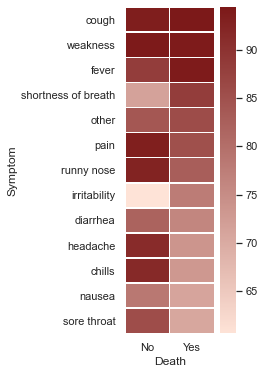

In [74]:
plt.figure(figsize=(2,6))
sns.heatmap(symptoms_death[['No', 'Yes']], linewidths=.5, cmap=cmap) 

### Recovery

Breakdown of recovered cases

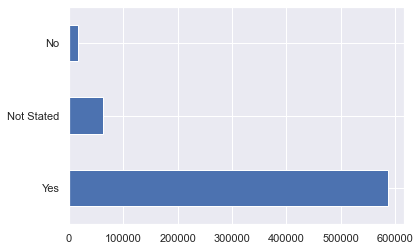

In [75]:
epi.Recovered.value_counts().plot.barh()

Number of recovered cases by age

In [7]:
epi.groupby(['Age group', 'Recovered']).size().unstack(0).fillna(0).reindex(['Yes', 'No', 'Not Stated'])

Age group,0 to 19,20 to 29,30 to 39,40 to 49,50 to 59,60 to 69,70 to 79,80 years or older
Recovered,,,,,,,,
Yes,8109.0,17062.0,16472.0,16870.0,16388.0,10116.0,6331.0,11131.0
No,0.0,0.0,0.0,0.0,189.0,625.0,1595.0,6157.0
Not Stated,1173.0,2465.0,1721.0,1347.0,1233.0,832.0,549.0,1096.0


Average time to recovery by age group. Episode week used as start of disesase, since Episode onset column is unreliable.


In [77]:
# Isolate recovered cases
recov = epi[epi['Recovery week'].notna()]
recov[['Episode week', 'Recovery week']] = recov[['Episode week', 'Recovery week']].astype(float)

# Calculate the lag between onset and recovery
recov['week_lag'] = recov['Recovery week'] - recov['Episode week']

recov_lags = recov.groupby('Age group').week_lag.describe()
recov_lags

C:\Users\Beto\miniconda3\envs\data\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-77-5bbb70ff513c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,std,min,25%,50%,75%,max
Age group,,,,,,,,
0 to 19,49099.0,1.913786,1.136979,0.0,1.0,2.0,2.0,38.0
20 to 29,47299.0,2.020022,1.177114,0.0,2.0,2.0,2.0,37.0
30 to 39,44250.0,2.040339,1.187395,0.0,2.0,2.0,2.0,38.0
40 to 49,42719.0,2.044196,1.085236,0.0,2.0,2.0,2.0,36.0
50 to 59,35645.0,2.095217,1.165721,0.0,2.0,2.0,2.0,14.0
60 to 69,21362.0,2.184252,1.227671,0.0,2.0,2.0,2.0,15.0
70 to 79,11864.0,2.432569,1.551718,0.0,2.0,2.0,3.0,36.0
80 years or older,15691.0,3.412338,1.778567,0.0,2.0,4.0,4.0,14.0


Plot average recovery time and the max for each age group.

Text(0.5, 1.0, 'Average and max recovery time (weeks) by age group')

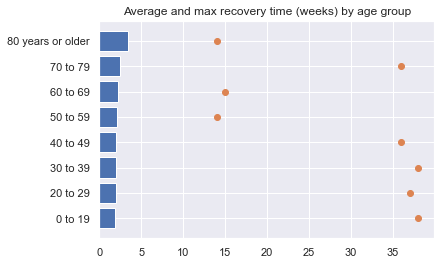

In [78]:
fig, ax = plt.subplots()
ax.barh(recov_lags.index, recov_lags['mean'])
ax.scatter(recov_lags['max'], recov_lags.index)
plt.title('Average and max recovery time (weeks) by age group')

Average recovery time by hospital status

In [79]:
recov.groupby('Hospital status').week_lag.mean()

Hospital status
Hospitalized and in ICU     3.363701
Hospitalized, not in ICU    2.963485
Not Stated/Unknown          2.714286
Not hospitalized            2.093047
Name: week_lag, dtype: float64

### Other variables

These are other columns in the data that didn't make it into the story. I leave them here for interest.

Transmission type over time. Note how infections from international travel pick up around week 26.

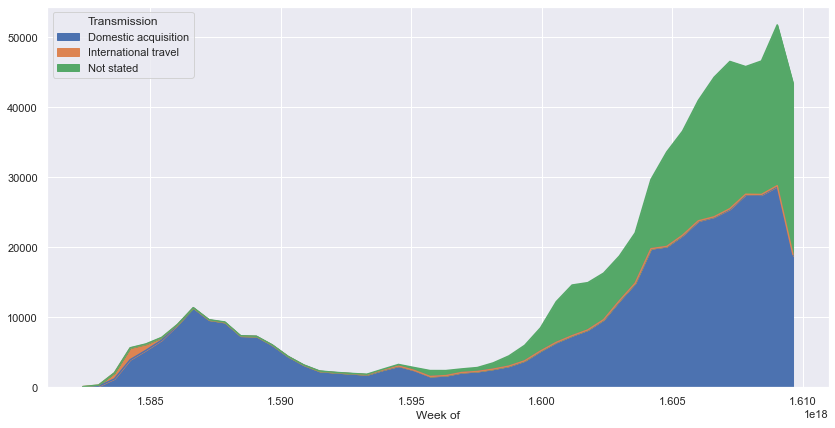

In [81]:
transmision_time = epi.groupby(['Week of', 'Transmission']).size().unstack()
transmision_time.index = transmision_time.index.astype(int)
transmision_time.sort_index().plot.area(figsize = (14,7))

Cases by region. StatCan lumps provinces together for privacy reasons, making this pretty useless.

In [82]:
epi['Region'].value_counts()

Ontario and Nunavut    228217
Quebec                 222111
Prairies and NWT       156027
BC and YK               57302
Atlantic                 2580
Name: Region, dtype: int64

Number of asymptomatic cases. Numbers too small to be useful.

In [83]:
epi.Asymptomatic.value_counts()

No            468157
Not Stated    147947
Yes            50133
Name: Asymptomatic, dtype: int64

Number of cases by occupation. Also not terribly useful.

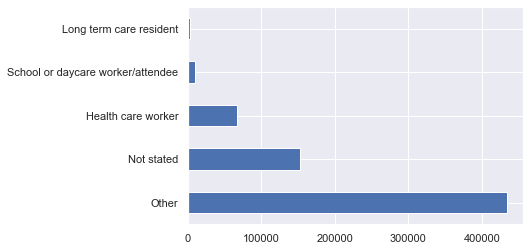

In [84]:
epi.Occupation.value_counts().plot.barh()

Number of deaths by occupation. Even less useful.

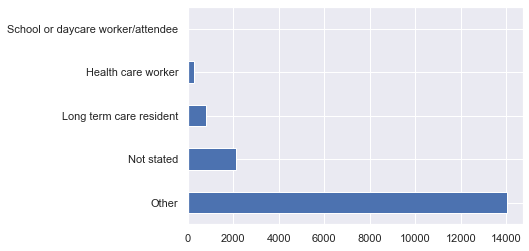

In [85]:
deaths_occupations = epi.query('Death == "Yes"').Occupation.value_counts()

deaths_occupations.plot.barh(stacked=True)